In [1]:
import pandas as pd
from pygam import LinearGAM, s
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import baseball_utilities

## Pre-Processing
1. Import players who have over 400 plate appearances in 2023 and 2024.
2. Import play-by-play data from Statcast in 2023 and 2024.
3. Filtered specific columns to keep in play-by-play data.
4. Filtered bunts from play-by-play data.

Problems: 2023 is limited in data as only the second half of 2023 data contained bat speed and swing length.

In [7]:
from baseball_utilities.display import *
set_pandas_display_all()
reset_pandas_display()

In [8]:
#Get players who have 400 plate appearances or more
from baseball_utilities.data import *
fangraphs_batting_min_400_2023 = get_table("fangraphs_batting_min_400_2023")
fangraphs_batting_min_400_2024 = get_table("fangraphs_batting_min_400_2024")

In [9]:
pbp_2023 = get_table("statcast_2023")
pbp_2024 = get_table("statcast_2024")

In [10]:
#Remove unnecessary columns
from baseball_utilities.preprocessing import *
columns_to_keep = ["pitch_type", 
                     "game_date", 
                     "release_speed", 
                     "player_name", 
                     "batter", 
                     "pitcher", 
                     "events",
                     "description",
                     "des", 
                     "zone",
                     "game_type",
                     "stand",
                     "p_throws",
                     "bb_type",
                     "balls",
                     "strikes",
                     "game_year",
                     "plate_x",
                     "plate_z",
                     "launch_speed",
                     "launch_angle",
                     "effective_speed",
                     "release_spin_rate",
                     "release_extension", 
                     "estimated_ba_using_speedangle",
                     "estimated_woba_using_speedangle",
                     "woba_value",
                     "arm_angle",
                     "bat_speed",
                     "swing_length"]
pbp_2023 = remove_columns(pbp_2023, columns_to_keep)
pbp_2024 = remove_columns(pbp_2024, columns_to_keep)

In [11]:
print(pbp_2023.shape)
print(pbp_2024.shape)

(717945, 30)
(708825, 30)


In [12]:
mlbam_ids_2023 = fangraphs_batting_min_400_2023["mlbam_id"]
pbp_2023 = pbp_2023[pbp_2023["batter"].isin(mlbam_ids_2023)]
mlbam_ids_2024 = fangraphs_batting_min_400_2024["mlbam_id"]
pbp_2024 = pbp_2024[pbp_2024["batter"].isin(mlbam_ids_2024)]

In [13]:
print(pbp_2023.shape)
print(pbp_2024.shape)

(454325, 30)
(444382, 30)


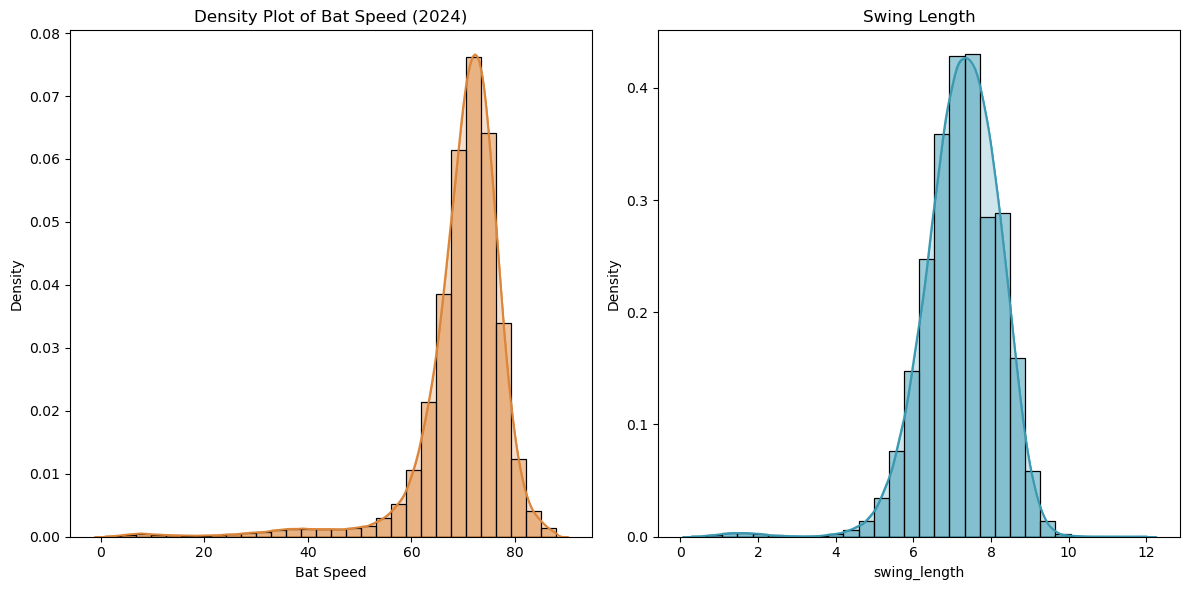

In [14]:
fig, axes = plt.subplots(1,2, figsize = (12,6))

sns.kdeplot(data = pbp_2024, x = 'bat_speed', fill = True, color = '#DC863B', ax = axes[0])
sns.histplot(pbp_2024['bat_speed'], kde = True, stat = "density", bins = 30, color = '#DC863B', edgecolor = "black", ax = axes[0])

axes[0].set_title("Density Plot of Bat Speed (2024)")
axes[0].set_xlabel("Bat Speed")
axes[0].set_ylabel("Density")
axes[1].set_ylabel("Density")

sns.kdeplot(data = pbp_2024, x = 'swing_length', fill = True, color = "#3B9AB2", ax = axes[1])
sns.histplot(pbp_2024['swing_length'], kde=True, stat="density", bins=30, color="#3B9AB2", edgecolor='black', ax = axes[1])

axes[1].set_title("Density Plot of Swing Length (2024)")
axes[1].set_title("Swing Length")

plt.tight_layout()

plt.show()

In [15]:
pbp_2024 = pbp_2024[
    ((pbp_2024['swing_length'] > 3) & (pbp_2024['bat_speed'] > 20)) |
    (pbp_2024['swing_length'].isna()) |
    (pbp_2024['bat_speed'].isna())
]

In [36]:
from baseball_processing.display import set_pandas_display_all
set_pandas_display_all()

In [18]:
swings_2023 = remove_nan(pbp_2023, ["bat_speed", "swing_length"])
swings_2024 = remove_nan(pbp_2024, ["bat_speed", "swing_length"])

363837 rows were dropped due to missing values in columns: ['bat_speed', 'swing_length']
246451 rows were dropped due to missing values in columns: ['bat_speed', 'swing_length']


In [19]:
#2023 only has data from post ASB
print(swings_2023.shape)
print(swings_2024.shape)

(90488, 30)
(196963, 30)


## YtY Average Swing Plots
Question: Is a swing consistent from a year-to-year basis and does the limited sample size from 2023 affect year-to-year correlations?

Result: As expected, year-to-year comparisons revealed strong correlation in means of bat speed and swing length. In contrast, standard deviation for bat speed was less consistent, likely because of its increased sensitivity to outliers, which will inflate variabilitity drastically.

In [11]:
#First step - compare player's yty swing length and bat speed to see if they're similar
average_swing_2023 = pbp_2023.groupby('batter').agg({
    'bat_speed' : ['mean','std'],
    'swing_length' : ['mean', 'std']})

average_swing_2023.columns = ['_'.join(col) for col in average_swing_2023.columns.values]

average_swing_2023 = average_swing_2023.rename(columns={
    'bat_speed_mean': 'bat_speed_mean_2023',
    'bat_speed_std': 'bat_speed_std_2023',
    'swing_length_mean': 'swing_length_mean_2023',
    'swing_length_std': 'swing_length_std_2023'})

average_swing_2024 = pbp_2024.groupby('batter').agg({
    'bat_speed': ['mean', 'std'],
    'swing_length': ['mean', 'std']})

average_swing_2024.columns = ['_'.join(col) for col in average_swing_2024.columns.values]

average_swing_2024 = average_swing_2024.rename(columns={
    'bat_speed_mean' : 'bat_speed_mean_2024',
    'bat_speed_std' : 'bat_speed_std_2024',
    'swing_length_mean': 'swing_length_mean_2024',
    'swing_length_std': 'swing_length_std_2024'})
yty_players = average_swing_2023.merge(average_swing_2024, on = 'batter', how = 'inner')

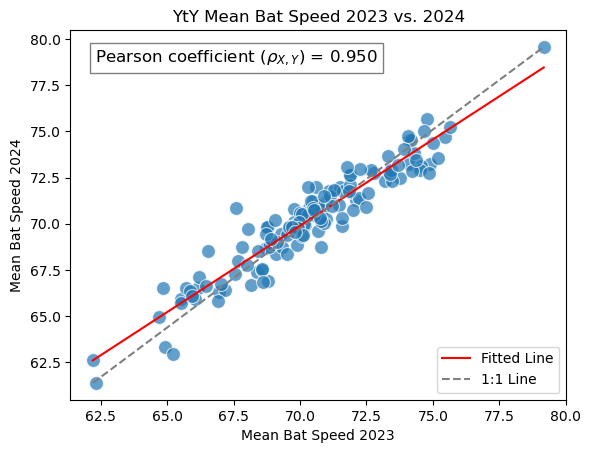

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress, pearsonr

x = yty_players['bat_speed_mean_2023']
y = yty_players['bat_speed_mean_2024']

slope, intercept, r_value, p_value, std_err = linregress(x,y)
r, pval = pearsonr(x, y)

x_val = np.linspace(x.min(), x.max(), 100)
y_val = intercept + slope * x_val

sns.scatterplot(x=x, y=y, s = 100, alpha=0.7)
plt.plot(x_val, y_val, color='red', label = 'Fitted Line')
plt.plot([x.min(), x.max()], [y.min(), y.max()], linestyle = '--', color = 'gray', label = '1:1 Line')
plt.title("YtY Mean Bat Speed 2023 vs. 2024")

plt.xlabel("Mean Bat Speed 2023")
plt.ylabel("Mean Bat Speed 2024")
plt.legend()

plt.gca().text(
    0.05, 0.95, 
    f'Pearson coefficient $(\\rho_{{X,Y}})$ = {r_value:.3f}',
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(facecolor='white', alpha=0.5)
)

    
plt.show()

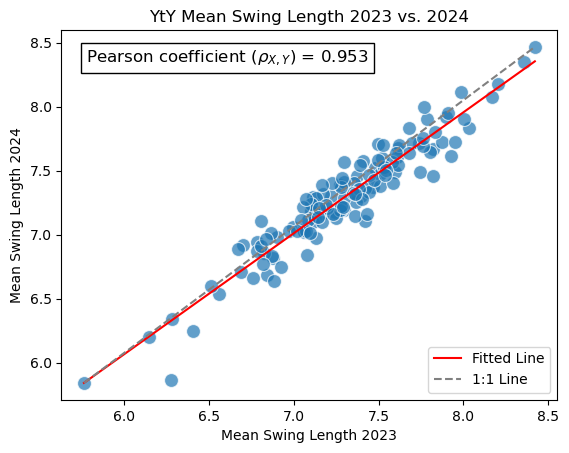

In [15]:
x = yty_players['swing_length_mean_2023']
y = yty_players['swing_length_mean_2024']

slope, intercept, r, _, _ = linregress(x,y)

x_val = np.linspace(x.min(), x.max(), 100)
y_val = intercept + slope * x_val

sns.scatterplot(x=x, y=y, s = 100, alpha = 0.7)
plt.plot(x_val, y_val, color = 'red', label = 'Fitted Line')
plt.plot([x.min(), x.max()], [y.min(), y.max()], linestyle = '--', color = 'gray', label = '1:1 Line')
plt.title("YtY Mean Swing Length 2023 vs. 2024")
plt.xlabel("Mean Swing Length 2023")
plt.ylabel("Mean Swing Length 2024")
plt.legend()

plt.gca().text(
    .05, .95,
    f'Pearson coefficient $(\\rho_{{X,Y}})$ = {r:.3f}', 
    transform = plt.gca().transAxes,
    fontsize = 12,
    verticalalignment = 'top',
    bbox = dict(facecolor='white', alpha = 1))
plt.show()


Text(0.05, 0.95, 'Pearson coefficient $(\\rho{X,Y})$ = 0.680')

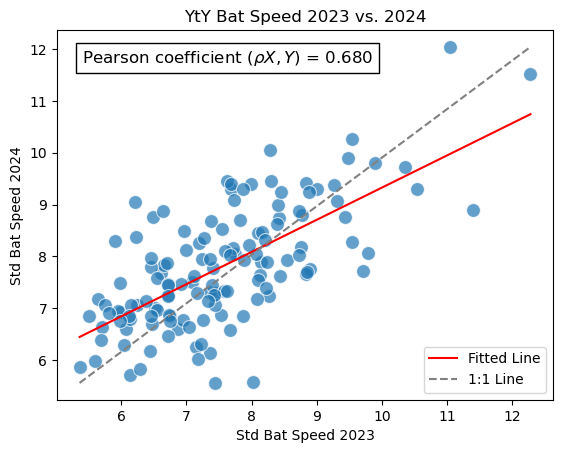

In [16]:
x = yty_players['bat_speed_std_2023']
y = yty_players['bat_speed_std_2024']

slope, intercept, r, _, _ = linregress(x,y)
x_val = np.linspace(x.min(), x.max(), 100)
y_val = intercept + slope * x_val

sns.scatterplot(x = x, y=y, s = 100, alpha = 0.7)
plt.plot(x_val, y_val, color = 'red', label = 'Fitted Line')
plt.plot([x.min(), x.max()], [y.min(), y.max()], linestyle = '--', color = 'gray', label = '1:1 Line')
plt.title("YtY Bat Speed 2023 vs. 2024")
plt.xlabel("Std Bat Speed 2023")
plt.ylabel("Std Bat Speed 2024")
plt.legend()

plt.gca().text(
    .05, .95,
    f'Pearson coefficient $(\\rho{{X,Y}})$ = {r:.3f}',
    transform = plt.gca().transAxes,
    fontsize = 12,
    verticalalignment = 'top',
    bbox = dict(facecolor = 'white', alpha = 1))

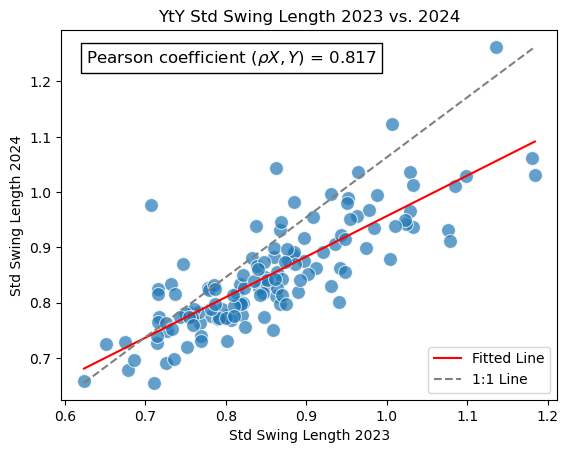

In [18]:
x = yty_players['swing_length_std_2023']
y = yty_players['swing_length_std_2024']

slope, intercept, r, _, _ = linregress(x,y)
x_val = np.linspace(x.min(), x.max(), 100)
y_val = intercept + slope * x_val

sns.scatterplot(x = x, y = y, s = 100, alpha = 0.7)
plt.plot(x_val, y_val, color = 'red', label = 'Fitted Line')
plt.plot([x.min(), x.max()], [y.min(), y.max()], linestyle = '--', color = 'gray', label = '1:1 Line')
plt.title("YtY Std Swing Length 2023 vs. 2024")
plt.xlabel("Std Swing Length 2023")
plt.ylabel("Std Swing Length 2024")
plt.legend()

plt.gca().text(
    .05,.95,
    f'Pearson coefficient $(\\rho{{X,Y}})$ = {r:.3f}',
    transform = plt.gca().transAxes,
    fontsize = 12,
    verticalalignment = 'top',
    bbox = dict(facecolor='white', alpha=1))
plt.show()

Results are as expected. The means for both years stabilize well, even with limited 2023 data. However, the standard deviation of bat speed exhibits the weakest year-to-year correlation. This is logical, as the smaller sample size in 2023 increases the sensitivity of the standard deviation to outliers.

## Modeling
- [1. Initial GAM based off of player-specific swings](#1-initial-gam-based-off-of-player-specific-swings)
- [2. Initial GAM with random effects](#2-initial-gam-with-random-effects)

### 1. Initial GAM based off of player-specific swings
Notes: Fine approximation, issues with release speed being wonky for slower pitches (75 mph Curves). Future idea, implement a mixed effect rather than player-specific effect in order to combat huge residuals for swings that are still expected to be normal.

In [35]:
swings_2023 = remove_nan(swings_2023, ["plate_x", "plate_z"])
swings_2024 = remove_nan(swings_2024, ["plate_x", "plate_z"])

No rows dropped.
No rows dropped.


In [25]:
from pygam import LinearGAM, s, te

removed_players_2023 = []

for idx, player_row in fangraphs_batting_min_400_2023.iterrows():
    mlbam_id = player_row["mlbam_id"]

    player_swings = swings_2023[swings_2023["batter"] == mlbam_id]

    if len(player_swings) < 250:
        removed_players_2023.append(player_row)
        continue

    X = player_swings[["plate_x", "plate_z"]].to_numpy()
    gam_speed = LinearGAM(te(0,1)).fit(X, player_swings["bat_speed"])
    gam_length = LinearGAM(te(0,1)).fit(X, player_swings["swing_length"])

    bat_speed_pred = gam_speed.predict(X)
    swing_length_pred = gam_length.predict(X)

    bat_speed_residual = player_swings["bat_speed"].values - bat_speed_pred
    swing_length_residual = player_swings["swing_length"].values - swing_length_pred

    swings_2023.loc[player_swings.index, "bat_speed_pred"] = bat_speed_pred
    swings_2023.loc[player_swings.index, "swing_length_pred"] = swing_length_pred
    swings_2023.loc[player_swings.index, "bat_speed_residual"] = bat_speed_residual
    swings_2023.loc[player_swings.index, "swing_length_residual"] = swing_length_residual


In [28]:
set_pandas_display_all()
swings_2024

,pitch_type,game_date,release_speed,player_name,batter,pitcher,events,description,des,zone,game_type,stand,p_throws,bb_type,balls,strikes,game_year,plate_x,plate_z,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,arm_angle,bat_speed,swing_length,bat_speed_pred,swing_length_pred,bat_speed_residual,swing_length_residual
18,FF,2024-09-30,94.2,"Díaz, Edwin",621566,621242,field_out,hit_into_play,Matt Olson pops out to shortstop Francisco Lindor.,12.0,R,L,R,popup,0,0,2024,0.84,2.93,76.1,58.0,96.5,2251.0,7.5,0.037,0.039,0.0,17.8,77.4,7.0,NaN,NaN,NaN,NaN
33,CU,2024-09-30,86.4,"Johnson, Pierce",596019,572955,home_run,hit_into_play,Francisco Lindor homers (33) on a fly ball to center field. Starling Marte scores.,8.0,R,L,R,fly_ball,0,0,2024,0.15,1.72,107.2,35.0,86.2,3025.0,5.9,0.791,1.621,2.0,39.4,80.2,8.1,NaN,NaN,NaN,NaN
40,SL,2024-09-30,89.7,"Díaz, Edwin",542303,621242,strikeout,swinging_strike,Marcell Ozuna strikes out swinging.,6.0,R,R,R,None,3,2,2024,0.55,2.52,NaN,NaN,92.1,2143.0,7.3,NaN,0.000,0.0,25.3,78.4,8.1,NaN,NaN,NaN,NaN
42,SL,2024-09-30,89.5,"Díaz, Edwin",542303,621242,None,swinging_strike,Marcell Ozuna strikes out swinging.,14.0,R,R,R,None,2,1,2024,0.94,1.28,NaN,NaN,91.7,2199.0,7.3,NaN,NaN,NaN,22.1,79.5,8.5,NaN,NaN,NaN,NaN
44,FF,2024-09-30,96.9,"Díaz, Edwin",542303,621242,None,foul,Marcell Ozuna strikes out swinging.,5.0,R,R,R,None,1,0,2024,-0.18,2.89,NaN,86.0,99.3,2254.0,7.6,NaN,NaN,NaN,18.4,77.4,8.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685132,SI,2024-04-03,92.3,"Keller, Mitch",682928,656605,field_out,hit_into_play,CJ Abrams pops out to third baseman Ke'Bryan Hayes in foul territory.,2.0,R,L,R,popup,3,1,2024,0.15,3.29,71.2,63.0,92.8,2317.0,6.5,0.003,0.003,0.0,31.7,64.2,6.2,NaN,NaN,NaN,NaN
685135,FF,2024-04-03,92.4,"Keller, Mitch",682928,656605,None,foul,CJ Abrams pops out to third baseman Ke'Bryan Hayes in foul territory.,2.0,R,L,R,None,1,0,2024,-0.03,3.10,71.5,35.0,93.0,2440.0,6.7,NaN,NaN,NaN,31.5,66.8,6.0,NaN,NaN,NaN,NaN
685140,CH,2024-04-03,83.3,"Williams, Trevor",668804,592866,field_out,hit_into_play,Bryan Reynolds lines out to right fielder Lane Thomas.,5.0,R,L,R,line_drive,1,1,2024,-0.23,2.54,98.9,21.0,83.7,1469.0,6.7,0.343,0.439,0.0,15.5,70.9,7.2,NaN,NaN,NaN,NaN
685143,CH,2024-04-03,82.5,"Williams, Trevor",665833,592866,strikeout,swinging_strike,Oneil Cruz strikes out swinging.,13.0,R,L,R,None,2,2,2024,-0.92,1.63,NaN,NaN,83.2,1395.0,6.7,NaN,0.000,0.0,14.8,82.1,8.5,NaN,NaN,NaN,NaN


In [30]:
from pygam import LinearGAM, s, te

removed_players_2024 = []

for idx, player_row in fangraphs_batting_min_400_2024.iterrows():
    mlbam_id = player_row["mlbam_id"]

    player_swings = swings_2024[swings_2024["batter"] == mlbam_id]

    if len(player_swings) < 500:
        removed_players_2024.append(player_row)
        continue

    X = player_swings[["plate_x", "plate_z"]].to_numpy()
    gam_speed = LinearGAM(te(0,1)).fit(X, player_swings["bat_speed"])
    gam_length = LinearGAM(te(0,1)).fit(X, player_swings["swing_length"])

    bat_speed_pred = gam_speed.predict(X)
    swing_length_pred = gam_length.predict(X)

    bat_speed_residual = player_swings["bat_speed"].values - bat_speed_pred
    swing_length_residual = player_swings["swing_length"].values - swing_length_pred

    swings_2024.loc[player_swings.index, "bat_speed_pred"] = bat_speed_pred
    swings_2024.loc[player_swings.index, "swing_length_pred"] = swing_length_pred
    swings_2024.loc[player_swings.index, "bat_speed_residual"] = bat_speed_residual
    swings_2024.loc[player_swings.index, "swing_length_residual"] = swing_length_residual

In [31]:
swings_2024

,pitch_type,game_date,release_speed,player_name,batter,pitcher,events,description,des,zone,game_type,stand,p_throws,bb_type,balls,strikes,game_year,plate_x,plate_z,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,arm_angle,bat_speed,swing_length,bat_speed_pred,swing_length_pred,bat_speed_residual,swing_length_residual
18,FF,2024-09-30,94.2,"Díaz, Edwin",621566,621242,field_out,hit_into_play,Matt Olson pops out to shortstop Francisco Lindor.,12.0,R,L,R,popup,0,0,2024,0.84,2.93,76.1,58.0,96.5,2251.0,7.5,0.037,0.039,0.0,17.8,77.4,7.0,72.630213,6.851235,4.769787,0.148765
33,CU,2024-09-30,86.4,"Johnson, Pierce",596019,572955,home_run,hit_into_play,Francisco Lindor homers (33) on a fly ball to center field. Starling Marte scores.,8.0,R,L,R,fly_ball,0,0,2024,0.15,1.72,107.2,35.0,86.2,3025.0,5.9,0.791,1.621,2.0,39.4,80.2,8.1,73.566324,7.948831,6.633676,0.151169
40,SL,2024-09-30,89.7,"Díaz, Edwin",542303,621242,strikeout,swinging_strike,Marcell Ozuna strikes out swinging.,6.0,R,R,R,None,3,2,2024,0.55,2.52,NaN,NaN,92.1,2143.0,7.3,NaN,0.000,0.0,25.3,78.4,8.1,74.373570,7.287232,4.026430,0.812768
42,SL,2024-09-30,89.5,"Díaz, Edwin",542303,621242,None,swinging_strike,Marcell Ozuna strikes out swinging.,14.0,R,R,R,None,2,1,2024,0.94,1.28,NaN,NaN,91.7,2199.0,7.3,NaN,NaN,NaN,22.1,79.5,8.5,69.598224,8.102444,9.901776,0.397556
44,FF,2024-09-30,96.9,"Díaz, Edwin",542303,621242,None,foul,Marcell Ozuna strikes out swinging.,5.0,R,R,R,None,1,0,2024,-0.18,2.89,NaN,86.0,99.3,2254.0,7.6,NaN,NaN,NaN,18.4,77.4,8.0,73.445847,6.833112,3.954153,1.166888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685132,SI,2024-04-03,92.3,"Keller, Mitch",682928,656605,field_out,hit_into_play,CJ Abrams pops out to third baseman Ke'Bryan Hayes in foul territory.,2.0,R,L,R,popup,3,1,2024,0.15,3.29,71.2,63.0,92.8,2317.0,6.5,0.003,0.003,0.0,31.7,64.2,6.2,67.746497,6.518272,-3.546497,-0.318272
685135,FF,2024-04-03,92.4,"Keller, Mitch",682928,656605,None,foul,CJ Abrams pops out to third baseman Ke'Bryan Hayes in foul territory.,2.0,R,L,R,None,1,0,2024,-0.03,3.10,71.5,35.0,93.0,2440.0,6.7,NaN,NaN,NaN,31.5,66.8,6.0,69.811933,6.778951,-3.011933,-0.778951
685140,CH,2024-04-03,83.3,"Williams, Trevor",668804,592866,field_out,hit_into_play,Bryan Reynolds lines out to right fielder Lane Thomas.,5.0,R,L,R,line_drive,1,1,2024,-0.23,2.54,98.9,21.0,83.7,1469.0,6.7,0.343,0.439,0.0,15.5,70.9,7.2,71.598932,6.546403,-0.698932,0.653597
685143,CH,2024-04-03,82.5,"Williams, Trevor",665833,592866,strikeout,swinging_strike,Oneil Cruz strikes out swinging.,13.0,R,L,R,None,2,2,2024,-0.92,1.63,NaN,NaN,83.2,1395.0,6.7,NaN,0.000,0.0,14.8,82.1,8.5,73.092508,8.483885,9.007492,0.016115


In [32]:
swings_2024.to_csv("swings_2024_residuals_appended.csv", index = False)

In [34]:
removed_players_2023_df = pd.DataFrame(removed_players_2023)
removed_players_2023_df

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,2B,3B,HR,R,RBI,BB,IBB,SO,HBP,SF,SH,GDP,SB,CS,AVG,GB,FB,LD,IFFB,Pitches,Balls,Strikes,IFH,BU,BUH,BB%,K%,BB/K,OBP,SLG,OPS,ISO,BABIP,GB/FB,LD%,GB%,FB%,IFFB%,HR/FB,IFH%,BUH%,wOBA,wRAA,wRC,Bat,Fld,Rep,Pos,RAR,WAR,Dol,Spd,wRC+,WPA,-WPA,+WPA,RE24,REW,pLI,phLI,PH,WPA/LI,Clutch,FB% (Pitch),FBv,SL%,SLv,CT%,CTv,CB%,CBv,CH%,CHv,SF%,SFv,KN%,KNv,XX%,PO%,wFB,wSL,wCT,wCB,wCH,wSF,wKN,wFB/C,wSL/C,wCT/C,wCB/C,wCH/C,wSF/C,wKN/C,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,F-Strike%,SwStr%,BsR,FA% (sc),FT% (sc),FC% (sc),FS% (sc),FO% (sc),SI% (sc),SL% (sc),CU% (sc),KC% (sc),EP% (sc),CH% (sc),SC% (sc),KN% (sc),UN% (sc),vFA (sc),vFT (sc),vFC (sc),vFS (sc),vFO (sc),vSI (sc),vSL (sc),vCU (sc),vKC (sc),vEP (sc),vCH (sc),vSC (sc),vKN (sc),FA-X (sc),FT-X (sc),FC-X (sc),FS-X (sc),FO-X (sc),SI-X (sc),SL-X (sc),CU-X (sc),KC-X (sc),EP-X (sc),CH-X (sc),SC-X (sc),KN-X (sc),FA-Z (sc),FT-Z (sc),FC-Z (sc),FS-Z (sc),FO-Z (sc),SI-Z (sc),SL-Z (sc),CU-Z (sc),KC-Z (sc),EP-Z (sc),CH-Z (sc),SC-Z (sc),KN-Z (sc),wFA (sc),wFT (sc),wFC (sc),wFS (sc),wFO (sc),wSI (sc),wSL (sc),wCU (sc),wKC (sc),wEP (sc),wCH (sc),wSC (sc),wKN (sc),wFA/C (sc),wFT/C (sc),wFC/C (sc),wFS/C (sc),wFO/C (sc),wSI/C (sc),wSL/C (sc),wCU/C (sc),wKC/C (sc),wEP/C (sc),wCH/C (sc),wSC/C (sc),wKN/C (sc),O-Swing% (sc),Z-Swing% (sc),Swing% (sc),O-Contact% (sc),Z-Contact% (sc),Contact% (sc),Zone% (sc),Pace,Def,wSB,UBR,Age Rng,Off,Lg,wGDP,Pull%,Cent%,Oppo%,Soft%,Med%,Hard%,TTO%,CH% (pi),CS% (pi),CU% (pi),FA% (pi),FC% (pi),FS% (pi),KN% (pi),SB% (pi),SI% (pi),SL% (pi),XX% (pi),vCH (pi),vCS (pi),vCU (pi),vFA (pi),vFC (pi),vFS (pi),vKN (pi),vSB (pi),vSI (pi),vSL (pi),vXX (pi),CH-X (pi),CS-X (pi),CU-X (pi),FA-X (pi),FC-X (pi),FS-X (pi),KN-X (pi),SB-X (pi),SI-X (pi),SL-X (pi),XX-X (pi),CH-Z (pi),CS-Z (pi),CU-Z (pi),FA-Z (pi),FC-Z (pi),FS-Z (pi),KN-Z (pi),SB-Z (pi),SI-Z (pi),SL-Z (pi),XX-Z (pi),wCH (pi),wCS (pi),wCU (pi),wFA (pi),wFC (pi),wFS (pi),wKN (pi),wSB (pi),wSI (pi),wSL (pi),wXX (pi),wCH/C (pi),wCS/C (pi),wCU/C (pi),wFA/C (pi),wFC/C (pi),wFS/C (pi),wKN/C (pi),wSB/C (pi),wSI/C (pi),wSL/C (pi),wXX/C (pi),O-Swing% (pi),Z-Swing% (pi),Swing% (pi),O-Contact% (pi),Z-Contact% (pi),Contact% (pi),Zone% (pi),Pace (pi),FRM,AVG+,BB%+,K%+,OBP+,SLG+,ISO+,BABIP+,LD+%,GB%+,FB%+,HR/FB%+,Pull%+,Cent%+,Oppo%+,Soft%+,Med%+,Hard%+,EV,LA,Barrels,Barrel%,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA,L-WAR,mlbam_id
10,12325,2023,Jace Peterson,- - -,33,134,374,430,79,59,10,4,6,35,37,47,2,101,4,3,2,7,15,2,0.211,113,105,54,5,1745,651,1094,3,6,2,0.109,0.235,0.47,0.304,0.307,0.611,0.096,0.270,0.0108,0.199,0.415,0.386,0.048,0.057,0.027,0.333,0.275,-15.6,37,-13.9,-0.1,13.4,1.3,4.1,0.4,$3.3,6.0,73,-2.92,-8.99,6.07,-12.89,-1.41,1.11,1.91,23,-1.61,-1.01,0.482,94.1,0.180,84.0,0.063,89.5,0.118,80.3,0.140,86.0,0.016,87.0,0.001,81.0,0.006,None,-8.4,-5.7,-0.2,-2.9,0.4,0.8,0.0,-1.00,-1.83,-0.19,-1.40,0.15,2.84,3.87,0.253,0.625,0.414,0.588,0.864,0.768,0.433,0.612,0.096,2.1,0.369,None,0.069,0.018,0.001,0.108,0.174,0.096,0.028,NaN,0.136,NaN,0.001,None,94.4,None,89.8,87.3,83.6,92.9,84.2,79.5,82.3,NaN,86.0,NaN,81.1,-3.2,None,0.2,-6.8,-7.3,-5.4,1.8,3.7,3.4,NaN,-8.0,NaN,-1.6,9.2,None,4.7,3.3,0.0,3.8,1.3,-5.5,-6.9,NaN,3.0,NaN,-1.7,-2.7,None,-0.5,0.8,-0.4,-6.1,-4.3,-3.5,-0.8,NaN,1.2,NaN,0.0,-0.43,None,-0.39,2.43,-21.92,-3.26,-1.41,-2.11,-1.57,NaN,0.50,NaN,3.87,0.229,0.588,0.414,0.505,0.864,0.768,0.517,18.2,1.1,1.3,0.5,33 - 33,-11.8,1.4,0.0,0.363,0.363,0.273,0.158,0.579,0.263,0.358,0.140,NaN,0.114,0.361,0.066,0.017,NaN,NaN,0.110,0.191,0.001,86.1,NaN,80.3,94.7,90.1,87.1,NaN,NaN,93.1,84.5,85.9,-7.6,NaN,4.7,-3.0,0.5,-6.0,NaN,NaN,-5.1,2.0,1.7,1.7,NaN,-7.8,8.3,3.9,1.2,NaN,NaN,2.9,0.0,10.9,0.7,NaN,-3.6,-2.1,-0.8,0.3,NaN,NaN,-5.0,-5.3,0.0,0.29,NaN,-1.85,-0.34,-0.67,1.10,NaN,NaN,-2.66,-1.62,2.69,0.231,0.583,0.414,0.511,0.862,0.768,0.521,18.2,NaN,85,129,102,95,74,58,91,0.99,98,102,45,88,105,112,102,112,81,85.7,14.4,13,0.047,110.1,78,0.281,278,0.205,0.300,0.216,0.332,0.287,0.3,607054
12,3473,2023,Anthony R

In [49]:
removed_players_2024_df = pd.DataFrame(removed_players_2024)
removed_players_2024_df

""


After setting minimum swings to 500, 2023 contains a lot of qualified hitters who have swings that can't be accounted for because they don't have enough swings. Something to keep an eye on for modeling but YtY means of both swing speed and length stabilizing leaves me confident that I'll be able to find a distribution for most hitters.

In [56]:
swings_2023_sorted_bs_resid = swings_2023.sort_values(by = 'bat_speed_residual', ascending=False)

swings_2023_sorted_bs_resid

,pitch_type,game_date,release_speed,player_name,batter,pitcher,events,description,des,zone,game_type,stand,p_throws,bb_type,balls,strikes,game_year,plate_x,plate_z,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,arm_angle,bat_speed,swing_length,bat_speed_pred,swing_length_pred,bat_speed_residual,swing_length_residual
83588,FC,2023-09-11,87.0,"Freeland, Kyle",664023,607536,strikeout,foul_tip,Ian Happ strikes out on a foul tip.,13.0,R,R,L,None,3,2,2023,-1.40,1.31,NaN,NaN,88.1,2269.0,6.6,NaN,0.000,0.0,18.6,84.9,8.1,59.040776,6.819633,25.859224,1.280367
256641,EP,2023-07-29,50.9,"Pinto, René",663656,650907,field_out,hit_into_play,Kyle Tucker pops out softly to catcher Christian Bethancourt in foul territory.,11.0,R,L,R,popup,2,1,2023,-0.49,4.09,57.2,87.0,48.6,1372.0,4.2,0.006,0.007,0.0,50.8,66.4,7.3,40.833130,4.738331,25.566870,2.561669
69754,FC,2023-09-14,91.4,"Schmidt, Clarke",657077,657376,None,swinging_strike,Alex Verdugo flies out to left fielder Giancarlo Stanton.,14.0,R,L,R,None,1,0,2023,1.43,1.98,NaN,NaN,92.1,2633.0,6.5,NaN,NaN,NaN,33.4,72.4,6.9,46.962062,5.291283,25.437938,1.608717
121436,SL,2023-09-02,85.2,"Elder, Bryce",605141,693821,None,foul,Mookie Betts called out on strikes.,14.0,R,R,R,None,0,2,2023,1.26,1.63,59.6,-65.0,85.4,2439.0,6.4,NaN,NaN,NaN,52.4,80.0,8.2,56.001563,7.670290,23.998437,0.529710
62475,CH,2023-09-16,82.7,"Mantiply, Joe",663538,573009,None,foul,Nico Hoerner singles on a line drive to left fielder Corbin Carroll.,14.0,R,R,L,None,1,2,2023,1.10,0.73,NaN,NaN,82.8,1643.0,6.5,NaN,NaN,NaN,17.3,83.5,8.5,60.085018,8.210381,23.414982,0.289619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35515,SL,2023-09-22,87.6,"Borucki, Ryan",682829,621366,None,foul_bunt,Elly De La Cruz flies out to center fielder Ji Hwan Bae.,1.0,R,R,L,None,0,0,2023,-0.71,3.50,NaN,NaN,88.1,2452.0,6.4,NaN,NaN,NaN,25.2,3.5,0.8,70.336226,6.274197,-66.836226,-5.474197
120521,FF,2023-09-02,90.4,"Chafin, Andrew",656941,605177,None,foul_bunt,Kyle Schwarber pops out to second baseman Brice Turang.,5.0,R,L,L,None,0,0,2023,-0.07,2.33,NaN,NaN,90.8,2035.0,6.8,NaN,NaN,NaN,55.4,10.3,1.5,77.341398,7.685914,-67.041398,-6.185914
127977,FF,2023-08-30,98.2,"Greene, Hunter",642731,668881,None,foul_bunt,Thairo Estrada singles on a fly ball to center fielder TJ Friedl. Casey Schmitt to 3rd.,4.0,R,R,R,None,0,0,2023,-0.35,2.47,NaN,NaN,98.5,2209.0,6.5,NaN,NaN,NaN,24.2,3.7,1.5,70.905171,6.932678,-67.205171,-5.432678
142267,SL,2023-08-27,86.5,"Hamilton, Ian",670042,641656,None,foul_bunt,"Luke Raley grounds out, second baseman Gleyber Torres to first baseman DJ LeMahieu.",5.0,R,L,R,None,0,0,2023,0.18,2.12,NaN,NaN,85.9,1418.0,6.0,NaN,NaN,NaN,41.8,6.6,1.8,74.740389,7.425936,-68.140389,-5.625936


In [ ]:
swings_2023_sorted_bs_resid = swings_2023.sort_values(by = 'bat_speed_residual', ascending=False)

swings_2023_sorted_bs_resid

In [45]:
jose_altuve_2024 = swings_2024[swings_2024["batter"] == 514888]

<Axes: xlabel='bat_speed', ylabel='swing_length'>

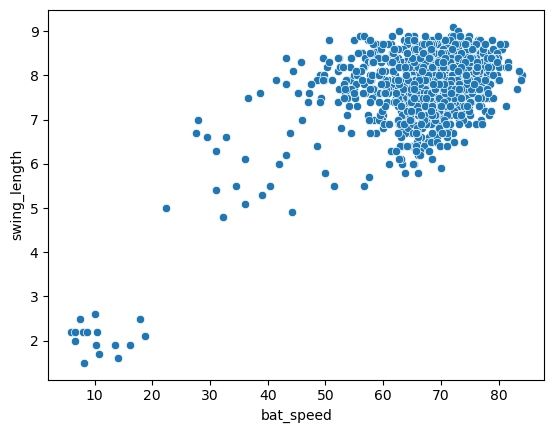

In [46]:
sns.scatterplot(data = jose_altuve_2024, x = "bat_speed", y = "swing_length")

In [44]:
swings_2024_sorted_bs_resid = swings_2024.sort_values(by = 'bat_speed_residual', ascending=False)

swings_2024_sorted_bs_resid

,pitch_type,game_date,release_speed,player_name,batter,pitcher,events,description,des,zone,game_type,stand,p_throws,bb_type,balls,strikes,game_year,plate_x,plate_z,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,arm_angle,bat_speed,swing_length,bat_speed_pred,swing_length_pred,bat_speed_residual,swing_length_residual
75320,SI,2024-09-10,95.4,"Ferguson, Tyler",514888,621053,None,foul,Jose Altuve singles on a fly ball to second baseman Zack Gelof. Jason Heyward scores.,13.0,R,R,R,None,1,1,2024,-1.76,1.85,NaN,NaN,94.7,2218.0,6.2,NaN,NaN,NaN,27.0,76.4,8.4,40.093734,4.810190,36.306266,3.589810
268500,ST,2024-07-23,87.4,"Jax, Griffin",656941,643377,None,foul,Kyle Schwarber flies out to center fielder Austin Martin.,14.0,R,L,R,None,1,2,2024,1.36,1.53,94.2,-13.0,87.4,3140.0,6.5,NaN,NaN,NaN,45.3,80.4,8.7,48.435922,7.598155,31.964078,1.101845
457834,SI,2024-06-01,93.1,"Fulmer, Carson",677594,608334,None,foul,Julio Rodríguez strikes out swinging.,11.0,R,R,R,None,0,1,2024,-1.76,2.63,59.2,62.0,92.8,2252.0,6.3,NaN,NaN,NaN,40.7,85.8,8.4,56.987370,6.602408,28.812630,1.797592
671097,FF,2024-04-06,92.8,"Lee, Dylan",664983,669276,None,foul,"Jake McCarthy grounds out softly, pitcher Dylan Lee to first baseman Matt Olson.",12.0,R,L,L,None,1,2,2024,0.11,4.19,83.2,58.0,92.6,2276.0,6.1,NaN,NaN,NaN,47.0,74.7,5.7,46.144957,4.251503,28.555043,1.448497
139347,CU,2024-08-25,77.2,"Assad, Javier",660821,665871,None,swinging_strike,Jesús Sánchez homers (16) on a fly ball to center field.,14.0,R,L,R,None,0,0,2024,0.44,0.06,NaN,NaN,76.5,2535.0,6.0,NaN,NaN,NaN,57.2,75.6,8.4,47.418649,7.533423,28.181351,0.866577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77436,FC,2024-09-10,88.9,"Darvish, Yu",670042,506433,None,foul_bunt,Luke Raley homers (19) on a fly ball to right field.,9.0,R,L,R,None,0,0,2024,0.32,1.84,NaN,NaN,89.6,2451.0,6.4,NaN,NaN,NaN,36.2,5.4,1.7,74.016315,7.421162,-68.616315,-5.721162
32968,SI,2024-09-21,92.1,"Suárez, Ranger",607043,624133,None,foul_bunt,"Brandon Nimmo grounds into a force out, second baseman Edmundo Sosa to shortstop Trea Turner. Pete Alonso out at 2nd. Brandon Nimmo to 1st.",8.0,R,L,L,None,0,0,2024,0.08,2.08,NaN,NaN,92.9,1929.0,6.6,NaN,NaN,NaN,45.6,6.0,2.1,74.645859,7.273783,-68.645859,-5.173783
274443,FF,2024-07-21,93.2,"Minter, A.J.",669357,621345,None,foul_bunt,Nolan Gorman pops out to first baseman Matt Olson in foul territory.,5.0,R,L,L,None,0,0,2024,0.12,2.87,NaN,NaN,93.4,2406.0,6.2,NaN,NaN,NaN,42.1,2.9,1.4,71.882629,6.735697,-68.982629,-5.335697
501088,ST,2024-05-20,79.8,"Lively, Ben",607043,594902,None,foul_bunt,Brandon Nimmo strikes out swinging.,5.0,R,L,R,None,2,1,2024,0.26,2.67,NaN,NaN,81.1,2075.0,6.9,NaN,NaN,NaN,37.5,2.4,1.2,72.584509,7.274422,-70.184509,-6.074422


### 2. Initial GAM with random effects